In [127]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class StationaryEncoder(nn.Module):
    def __init__(self, input_dim, feature_dim, d, w):
        """
        Args:
            input_dim (int): Dimensionality of input vector x.
            feature_dim (int): Number of features generated per input (basis functions).
            d (int): Dimensionality of the final representation.
            w (float): Controls the frequency of cosine basis functions (related to Gaussian width).
        """
        super(StationaryEncoder, self).__init__()
        self.input_dim = input_dim
        self.feature_dim = feature_dim
        self.d = d
        self.w = w
        
        # Create deterministic frequencies for the cosine features
        self.freqs = torch.linspace(0, np.pi / w, feature_dim//2)  # Linearly spaced frequencies
        self.freq_norms = torch.linspace(1, feature_dim//2-1, feature_dim//2)**(-2)
        # Initialize a random d x d matrix
        self.random_matrix = nn.Parameter(torch.randn(d, d), requires_grad=False)
        
        # Scaling factor for output norm
        self.scale = np.sqrt(2 / feature_dim)
    
    def forward(self, x):
        """
        Forward pass of the encoder.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
        
        Returns:
            torch.Tensor: Encoded tensor of shape (batch_size, d).
        """
        batch_size = x.shape[0]
        
        # Generate deterministic feature representations (cosine features)
        # x: (batch_size, input_dim)
        features = []
        for i in range(self.input_dim):
            cos_features = self.freq_norms*torch.cos(self.freqs * x[:, i].unsqueeze(-1))  # Shape: (batch_size, feature_dim)
            sin_features = self.freq_norms*torch.sin(self.freqs * x[:, i].unsqueeze(-1))  # Shape: (batch_size, feature_dim)
            circ_features = torch.concat([cos_features,sin_features],dim=-1)
            print(sin_features.shape,circ_features.shape)
            features.append(circ_features)
        
        # Concatenate features across input dimensions
        features = torch.cat(features, dim=-1)  # Shape: (batch_size, input_dim * feature_dim)
        print(features.shape)

        # Scale features
        features = self.scale * features
        
        # Pass through random projection matrix
        output = F.linear(features, self.random_matrix)  # Shape: (batch_size, d)
        
        # Normalize output amplitude (ensures uniform norm across neurons)
        output = output / output.norm(dim=-1, keepdim=True) * np.sqrt(self.d)
        
        return output


In [152]:
encoder = StationaryEncoder(1,1024,1024,20)

In [153]:
x = np.float32([np.linspace(-400,400,100)]).T

In [154]:
x.shape

(100, 1)

In [155]:
o = encoder(torch.tensor(x)).detach().numpy()

torch.Size([100, 512]) torch.Size([100, 1024])
torch.Size([100, 1024])


In [156]:
import matplotlib.pyplot as plt

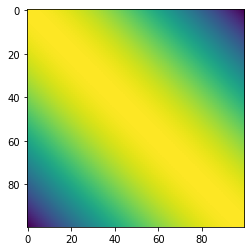

In [157]:
c = o@o.T
plt.imshow(c)

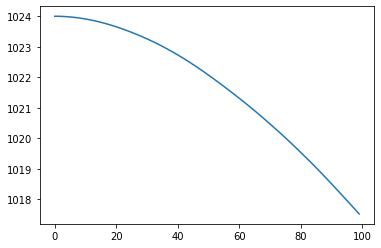

In [158]:
plt.plot(c[0])

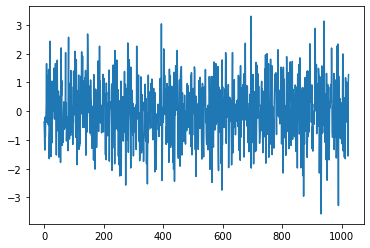

In [38]:
plt.plot(o[6])

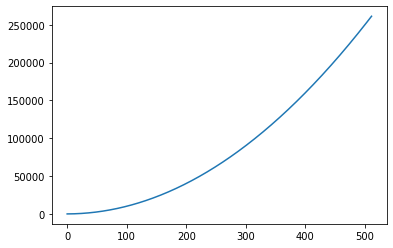

In [151]:
plt.plot(1./encoder.freq_norms.numpy())